In [182]:
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import *
import numpy as np

# 1.REAL data

## 1.1 GFF and BED readers

In [80]:
def read_gff(file_path):
    columns = ['chromosome', 'source', 'type', 'start', 'end', 
               'score', 'strand', 'phase', 'attributes']
    gff = pd.read_csv(file_path, sep='\t', names=columns)
    gff = gff[~gff['chromosome'].str.contains('#')]
    return gff

def read_bed6(file_path):
    columns = ['chromosome','start','end','name','score','strand']
    return pd.read_csv(file_path, sep='\t', names=columns)



beds = read_bed6('alignment.bed')
gffs = read_gff('rrna_annotation.gff')

In [81]:
beds.head()

,chromosome,start,end,name,score,strand
0,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-
1,Reference_1,202886,202996,NODE_19543_length_110_cov_1549.290909,0,-
2,Reference_1,202941,203377,NODE_5666_length_436_cov_418.653543,16,+
3,Reference_1,203322,785222,NODE_25_length_581906_cov_146.024228,60,+
4,Reference_1,785169,1763981,NODE_11_length_978812_cov_132.517515,60,-


In [83]:
gffs

,chromosome,source,type,start,end,score,strand,phase,attributes
1,Reference_10,barrnap:0.9,rRNA,67122.0,68652.0,0.000000e+00,+,.,Name=16S_rRNA;product=16S ribosomal RNA
2,Reference_10,barrnap:0.9,rRNA,68981.0,72061.0,0.000000e+00,+,.,Name=23S_rRNA;product=23S ribosomal RNA
3,Reference_10,barrnap:0.9,rRNA,469298.0,470826.0,0.000000e+00,+,.,Name=16S_rRNA;product=16S ribosomal RNA
4,Reference_10,barrnap:0.9,rRNA,471166.0,474246.0,0.000000e+00,+,.,Name=23S_rRNA;product=23S ribosomal RNA
5,Reference_10,barrnap:0.9,rRNA,3629599.0,3632680.0,0.000000e+00,-,.,Name=23S_rRNA;product=23S ribosomal RNA
...,...,...,...,...,...,...,...,...,...
344,Reference_25,barrnap:0.9,rRNA,1819878.0,1822785.0,0.000000e+00,+,.,Name=23S_rRNA;product=23S ribosomal RNA
345,Reference_25,barrnap:0.9,rRNA,1822913.0,1823016.0,2.900000e-10,+,.,Name=5S_rRNA;product=5S ribosomal RNA
346,Reference_25,barrnap:0.9,rRNA,3744056.0,3744159.0,2.900000e-10,-,.,Name=5S_rRNA;product=5S ribosomal RNA
347,Reference_25,barrnap:0.9,rRNA,3744287.0,3747194.0,0.000000e+00,-,.,Name=23S_rRNA;product=23S ribosomal RNA


## 1.2 rRNA attributes

In [71]:
gffs['attributes'] = gffs['attributes'].str.extract("=(.+?S)")
gffs.head()

,chromosome,source,type,start,end,score,strand,phase,attributes
0,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,16S
1,Reference_10,barrnap:0.9,rRNA,68981,72061,0.0,+,.,23S
2,Reference_10,barrnap:0.9,rRNA,469298,470826,0.0,+,.,16S
3,Reference_10,barrnap:0.9,rRNA,471166,474246,0.0,+,.,23S
4,Reference_10,barrnap:0.9,rRNA,3629599,3632680,0.0,-,.,23S


## 1.3 Ugly rRNA_barplot

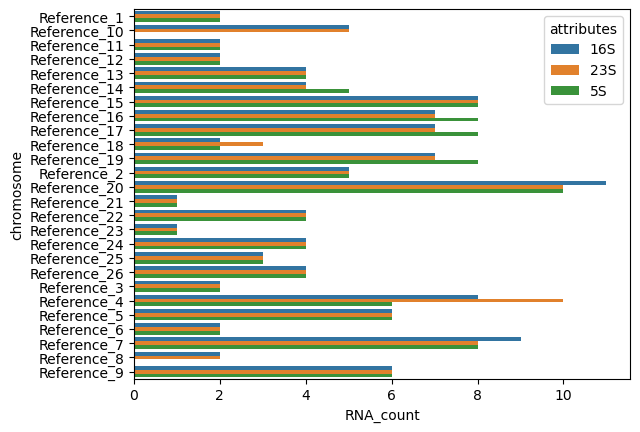

In [7]:
RNAs = gffs.groupby(['chromosome','attributes'], as_index=False).agg(RNA_count=('type','count'))
rRNA_barplot = sns.barplot(data=RNAs, hue='attributes', y='chromosome', x='RNA_count')

## 1.4 Poor man's bedtools intersect 

Получаем при помощи мерджа декартово произведение двух матриц - все возможные сочетания между референсами и контигами (ведь 1 контиг может содержать несколько референсов)

In [33]:
merged = gffs.merge(beds, how='inner', on='chromosome')

Ищем пересечения между контигами и референсами при помощи одноименной функции:

In [34]:


def intersect(ass, ae, bs, be):
    if (bs>ae or ass>be):
        return None
    else:
        os = max(ass, bs)
        oe = min(ae, be)
        result = [os, oe]
        return result
    
    

In [35]:
merged['intersection'] = merged\
    .apply(lambda x: intersect(x.start_x, x.end_x, x.start_y, x.end_y), axis=1)
merged = merged.dropna(subset='intersection')
#сбрасываем непересеченные с референсами риды

In [36]:
merged[['inter_start','inter_end']] = pd.DataFrame(
    merged.intersection.tolist(), index=merged.index)
merged = merged.sort_values(by=['start_x','inter_start','inter_end'])
#сортируем риды

Команда ниже позволяет смотреть пересекается ли конец контига с началом следующего контига - если пересекается, то они создают непрерывную последовательность. Далее команда считает число пересекающихся друг с другом ридом. 

In [13]:
(merged['inter_start']<=merged['inter_end'].shift(1)).astype(int).sum()


391

Если все отсортированные контиги принадлежащие одному референсу пересекаются друг с другом и включают в себя начало и конец референса - они полностью покрывает референс. При этом число пересечени в этом случае равно числу контигов-1

In [59]:
overlaps = merged.groupby('start_x',as_index=False)\
    .apply(lambda x: (x['inter_start']<=x['inter_end'].shift(1)).astype(int).sum())
overlaps = overlaps.rename(columns = {None:'overlaps'})
overlaps.head()

,start_x,overlaps
0,7192,1
1,9734,1
2,10171,0
3,11520,6
4,11870,2


Отбираем подходящие контиги: пересечений на 1 меньше, чем контигов, начало и конец референса входят в пересечение

In [62]:
contig_data = merged\
    .groupby(['start_x','end_x','chromosome','attributes'], as_index=False)\
    .agg(first_inter_start=("inter_start","min"), 
         last_inter_end=("inter_end","max"), 
         all_contigs=('name',lambda x: list(x)), 
         contigs=('source','count'))
contig_overlaps = contig_data.merge(overlaps, on='start_x', how='inner')
start_end = contig_overlaps[(contig_overlaps['start_x']>=contig_overlaps['first_inter_start']) 
                            & (contig_overlaps['end_x']<=contig_overlaps['last_inter_end'])]
full_RNAs = start_end[start_end['contigs']-1 == start_end['overlaps']]
full_RNAs

,start_x,end_x,chromosome,attributes,first_inter_start,last_inter_end,all_contigs,contigs,overlaps
4,11870,14771,Reference_15,23S,11870,14771,"[NODE_1362_length_2984_cov_403.960055, NODE_19...",3,2
5,14596,14704,Reference_4,5S,14596,14704,[NODE_622_length_27379_cov_483.139950],1,0
6,14886,14983,Reference_15,5S,14886,14983,[NODE_369_length_57733_cov_63.793769],1,0
9,22028,22137,Reference_5,5S,22028,22137,"[NODE_3820_length_683_cov_392.977707, NODE_489...",2,1
12,28029,28138,Reference_5,5S,28029,28138,[NODE_3820_length_683_cov_392.977707],1,0
...,...,...,...,...,...,...,...,...,...
311,4751643,4754533,Reference_26,23S,4751643,4754533,"[NODE_1329_length_3169_cov_103.935132, NODE_19...",2,1
312,4754656,4756174,Reference_26,16S,4754656,4756174,"[NODE_19238_length_176_cov_67.305785, NODE_200...",3,2
313,5532457,5532551,Reference_26,5S,5532457,5532551,"[NODE_6123_length_406_cov_55.763533, NODE_1927...",3,2
314,5532663,5535553,Reference_26,23S,5532663,5535553,"[NODE_1329_length_3169_cov_103.935132, NODE_19...",2,1


 # 2. Chart customization

In [88]:
diff_exp = pd.read_csv('diffexpr_data.tsv.gz', sep='\t')
diff_exp

    

,Sample,logFC,pval,pval_corr,log_pval
0,PNLIP,10.092524,6.590327e-01,1.000000e+00,-0.000000
1,CELA2A,8.691414,5.823905e-01,1.000000e+00,-0.000000
2,CLPS,8.054078,6.517331e-01,1.000000e+00,-0.000000
3,MPO,7.817773,4.483336e-01,1.000000e+00,-0.000000
4,AMY2A,7.285231,6.324412e-01,1.000000e+00,-0.000000
...,...,...,...,...,...
20525,SLC12A1,-7.834589,4.993254e-58,1.025115e-53,52.989227
20526,SEMG2,-8.651953,3.989840e-04,1.000000e+00,-0.000000
20527,MUC7,-9.196481,3.281804e-07,6.737544e-03,2.171498
20528,SEMG1,-9.313028,3.880575e-04,1.000000e+00,-0.000000


In [126]:
def gene_group(logFC, pval_corr):
    if pval_corr <= 0.05:
        sign = 'Significantly'
    else:
        sign = 'Non-significantly'
    if logFC >= 0:
        expr = 'upregulated'
    else:
        expr = 'downregulated'
    return f'{sign} {expr}'
order = ['Significantly downregulated','Significantly upregulated',
         'Non-significantly downregulated', 'Non-significantly upregulated']

In [127]:
diff_exp['gene_type'] = diff_exp.apply(
    lambda x: gene_group(x.logFC, x.pval_corr), axis = 1)

In [326]:
sign = diff_exp[diff_exp['gene_type'].str.contains('S')]
sign = sign.sort_values(by='logFC')
top = pd.concat([sign.head(2), sign.tail(2)])
top

,Sample,logFC,pval,pval_corr,log_pval,gene_type
20529,UMOD,-10.661093,3.717350e-57,7.631720e-53,52.117378,Significantly downregulated
20527,MUC7,-9.196481,3.281804e-07,6.737544e-03,2.171498,Significantly downregulated
88,ZIC5,4.276745,3.686245e-09,7.567860e-05,4.121027,Significantly upregulated
64,ZIC2,4.571915,4.096640e-08,8.410403e-04,3.075183,Significantly upregulated


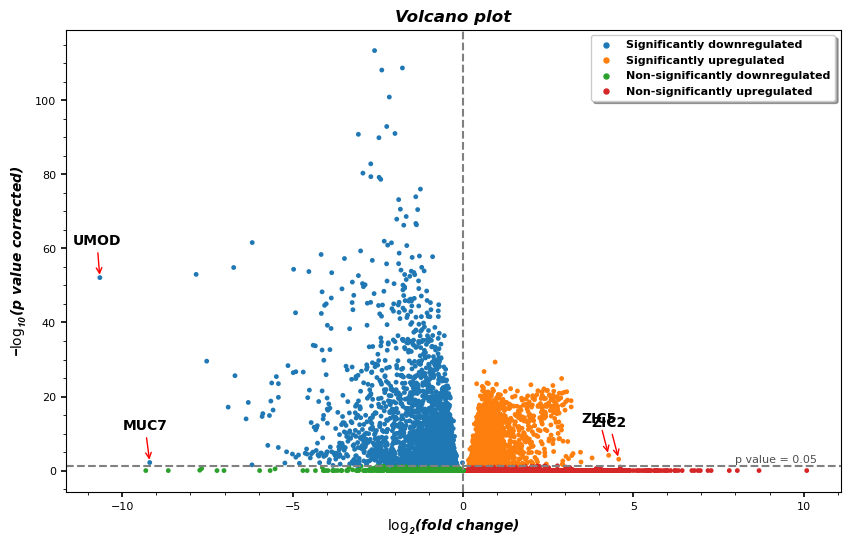

In [379]:
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:italic:bold'
figure(figsize=(10, 6), dpi=100)
ax = sns.scatterplot(data = diff_exp, x = 'logFC',
                     y = 'log_pval', hue = 'gene_type', 
                     hue_order = order, s = 12, linewidth = 0)
ax.axhline(-np.log10(0.05), c='0.5', ls = '--')
ax.axvline(0, c='0.5', ls = '--')
ax.set_xlabel(r'$\mathbf{\log_{2}}$(fold change)', 
              weight='bold', style='italic')
ax.set_ylabel(r'$\mathbf{-\log_{10}}$(p value corrected)', 
              weight='bold', style='italic')
ax.tick_params(axis='both', which='major', labelsize=8, width = 1.2)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax = plt.gca()
ax.set_xlim([diff_exp['logFC'].min()-1, diff_exp['logFC'].max()+1])
plt.title('Volcano plot', weight='bold', style='italic')
legend_properties = {'weight':'bold', 'size':8}
plt.legend(prop=legend_properties, shadow=True, markerscale=0.6)
plt.text(8, -np.log10(0.05)+1, 'p value = 0.05', c='0.3', fontsize=8)
for index, row in top.iterrows():
    plt.annotate(row['Sample'], 
                 (row['logFC'], row['log_pval']), 
                 xytext=(row['logFC']-0.8, row['log_pval']+9), 
                 arrowprops={"arrowstyle":"->", 'linewidth':1,'edgecolor':'r'}, 
                 weight='bold')

In [341]:
for index, row in top.iterrows():
    print(row['Sample'], row['logFC'], row['log_pval'])

UMOD -10.661092815248146 52.117377544152994
MUC7 -9.196480736032145 2.1714983637317933
ZIC5 4.276744759172447 4.121026900094742
ZIC2 4.5719153784763975 3.075183198225649
